In [1]:
import gym.envs.toy_text.frozen_lake as frozen_lake # I guess `toy_text` is a separate package?
from gym import make
import gym
from gym.envs.registration import register, registry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myenv
from pprint import pprint
import warnings
import xlrd
import time
from matplotlib import colors

In [2]:
# These are the non-random maps
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "16x16" : [
        'SFFFFFHHFFFFFFFF',
        'FFFFHFFHFFFFFFHF',
        'FHFFFFFHFHFHFFFF',
        'HFFHFFFFFFFFFHFH',
        'FHFFFFHHFFFHHFHF',
        'FHFFHFHFFFFHFFFF',
        'FFHFFFFHFFFHHHHF',
        'HFHFFFFFFFFFFFFH',
        'FFFFFFFFFHFFFFHF',
        'FFFFFFHHFHFFFFFH',
        'FFHFFFFFFHFFFHFF',
        'FFFHHFHFFFFFHFFF',
        'FFFFFHFHFFFFHFFF',
        'HHHHHFFFHFFHFFFF',
        'FHFFHFFFFFFFFFFF',
        'FFHFHHFFHFFFFFFG'
    ]
}

In [3]:
def sixteen_by_sixteen_map():
    return frozen_lake.generate_random_map(size=16)

In [4]:
# ##
# Utility Functions
# ##

def getStateReward(env):
    n_states = env.observation_space.n
    Rs = np.empty(n_states)
    Rs.fill(np.nan)
    p = env.P
    for state in p:
        for action_commanded in p[state]:
            for action_possible in p[state][action_commanded]:
                Rs[action_possible[1]] = action_possible[2]
    
    return Rs 

In [5]:
def getReward(env):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    
    R = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a, moves in env.P[s].items():
            for possible_move in moves:
                prob, _, r, _ = possible_move
                R[s, a] += r * prob
    
    return R

def getProb(env):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    
    P = np.zeros((n_states, n_actions, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for moves in env.P[s][a]:
                prob, next_s, _, _ = moves
                P[s, a, next_s] += prob
    
    return P

def print_value(V, width=4, height=4):
    return np.around(np.resize(V, (width, height)), 4)

# https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
# matprint.py Pretty print a matrix in Python 3 with numpy
def matprint(mat, fmt="g"):
    if mat[0][0] in ["←", "↓", "→", "↑"]:
        fmt = 's'# fmt='s' for arrows
    if mat[0][0] in [b'S', b'F', b'H', b'G']:
        fmt = 's'
        mat = mat.astype('<U8')
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [6]:
# let's plot the policy matrix (as in Part 1). according to
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
# LEFT = 0   DOWN = 1   RIGHT = 2  UP = 3
def print_policy(V, width=4, height=4):
    table = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    policy = np.resize(V, (width, height))
    
    # transform using the dictionary
    return np.vectorize(table.get)(policy)

In [7]:
# ##
# Generate a Customized Frozen Lake
# ##

def getEnv(env_id='default', rH=0, rG=1, rF=0, desc=None, map_name='4x4', is_slippery=True, render_initial=True):

    if env_id in gym.envs.registry.env_specs:
        del gym.envs.registry.env_specs[env_id]

    register(
        id=env_id, # name given to this new environment
        entry_point='myenv:CustomizedFrozenLake', # env entry point
        kwargs={'rH': rH, 'rG': rG, 'rF': rF, 
                'desc': desc,
                'map_name': map_name, 
                'is_slippery': is_slippery} # argument passed to the env
    )

    this_env = make(env_id)

    if render_initial:
        print('--Board--')
        this_env.render()
        print('\n--Actions for Position to the Left of the Goal--')
        pprint(this_env.P[this_env.nS - 2])
    
    return this_env

In [8]:
#Default settings, uncomment to just use these
settings = {'rH': [-1],
 'rG': [1],
 'rF': [-0.2],
 'size': [16],
 'p': [0.8],
 'is_slippery': [False],
 'render_initial': [True],
 'epsilon': [1e-08],
 'gamma': [0.8],
 'max_iter': [10000],
 'qepsilon': [0.1],
 'lr': [0.8],
 'qgamma': [0.95],
 'episodes': [10000],
 'initial': [1],
 'decay': [True],
 'report': [True],
 'display_print': [True]}

In [9]:
# Determine the number of runs
n_settings = len(settings['rH'])
print(n_settings)

1


In [10]:
n=0
# Load settings
rH = settings['rH'][n] # -1 #-5 # reward for H(ole)
rG = settings['rG'][n] #1 # 10 # reward for G(oal)
rF = settings['rF'][n] #-0.2# reward includes S(tart) and F(rozen)
size = settings['size'][n] #4 # height and width of square gridworld, [4, 8, 16] are included in cs7641assn4.py 
p = settings['p'][n] #0.8 # if generating a random map probability that a grid will be F(rozen)
map_name = 'x'.join([str(size)]*2) # None, if you want a random map
desc = MAPS[map_name] # None, if you want a random map
is_slippery = settings['is_slippery'][n] #False
render_initial = settings['render_initial'][n] # True

epsilon = settings['epsilon'][n] #1e-8 # convergence threshold for policy/value iteration
gamma = settings['gamma'][n] #0.8 # discount parameter for past policy/value iterations
max_iter = settings['max_iter'][n] #10000 # maximum iterations for slowly converging policy/value iteration 

# Qlearning(env, rH=0, rG=1, rF=0, qepsilon=0.1, lr=0.8, gamma=0.95, episodes=10000)
qepsilon = settings['qepsilon'][n] #0.1 # epsilon value for the Q-learning epsilon greedy strategy
lr = settings['lr'][n] #0.8 # Q-learning rate
qgamma = settings['qgamma'][n] #0.95 # Q-Learning discount factor
episodes = settings['episodes'][n] #10000 # number of Q-learning episodes
initial = settings['initial'][n] #0 # value to initialize the Q grid
decay = settings['decay'][n] #True

# Printing options
report = settings['report'][n] #True # For cs7641assn4.py policy and value iteration functions
display_print = settings['display_print'][n] #True # For this script

# Create Environment
env = getEnv(env_id='hw4-FrozenLake-v0', rH=rH, rG=rG, rF=rF, 
                desc=desc,  
                is_slippery=is_slippery, render_initial=True)

# Store a representation of the map
env_desc = env.desc.astype('<U8')

# Store a representation of the state rewards
env_rs = getStateReward(env)

if display_print:
    # Display reward at each state
    print('\n--Reward Values at Each State--')
    matprint(print_value(env_rs, width=size, height=size))

--Board--

SFFFFFHHFFFFFFFF
FFFFHFFHFFFFFFHF
FHFFFFFHFHFHFFFF
HFFHFFFFFFFFFHFH
FHFFFFHHFFFHHFHF
FHFFHFHFFFFHFFFF
FFHFFFFHFFFHHHHF
HFHFFFFFFFFFFFFH
FFFFFFFFFHFFFFHF
FFFFFFHHFHFFFFFH
FFHFFFFFFHFFFHFF
FFFHHFHFFFFFHFFF
FFFFFHFHFFFFHFFF
HHHHHFFFHFFHFFFF
FHFFHFFFFFFFFFFF
FFHFHHFFHFFFFFFG

--Actions for Position to the Left of the Goal--
{0: [(1.0, 253, -0.2, False)],
 1: [(1.0, 254, -0.2, False)],
 2: [(1.0, 255, 1, True)],
 3: [(1.0, 238, -0.2, False)]}

--Reward Values at Each State--
-0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
-0.2  -0.2  -0.2  -0.2    -1  -0.2  -0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2  
-0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2    -1  -0.2    -1  -0.2  -0.2  -0.2  -0.2  
  -1  -0.2  -0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2    -1  
-0.2    -1  -0.2  -0.2  -0.2  -0.2    -1    -1  -0.2  -0.2  -0.2    -1    -1  -0.2    -1  -0.2  
-0.2    -1  -0.2  -0.2    -1 

In [11]:
n_observations = env.observation_space.n
n_actions = env.action_space.n

#Initialize the Q-table to 0
Q_table = np.zeros((n_observations,n_actions))

#number of episode we will run
n_episodes = 10000

#maximum of iteration per episode
max_iter_episode = 100

#initialize the exploration probability to 1
exploration_proba = 1

#exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

#discounted factor
gamma = 0.98

#learning rate
lr = 0.1

In [12]:
rewards_per_episode = list()
times_per_episode = list()
#we iterate over episodes
for e in range(n_episodes):
    
    if(e%500==0):
        print('episode = ', e)
    #we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    #contains the sum the rewards that the agent gets from the environment
    total_episode_reward = 0
    start=time.time()
    for i in range(max_iter_episode):
        # we sample a float from a uniform distribution between 0 and 1
        # if the sampled flaot is less than the exploration probability
        #    the agent explore the environment by choosing a random action
        # else
        #    he exploit his knowledge using the bellman equation 
        if np.random.uniform(0,1) < exploration_proba:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current_state,:])
        
        # The environment runs the choen action and returns the next state,
        # the reward for that action and true if the epiosed is ended.
        next_state, reward, done, _ = env.step(action)
        
        # We update our Q-table using the Q-learning iteration equation
        Q_table[current_state, action] = (1-lr)*Q_table[current_state, action] + lr*(reward + gamma*max(Q_table[next_state,:]))
        total_episode_reward = total_episode_reward + reward
        
        # If the episode is finished, we leave the for loop
        if done:
            break
        current_state = next_state
    # We update our exploration probability using exponential decay formula 
    exploration_proba = max(min_exploration_proba,np.exp(-exploration_decreasing_decay*e))
    end=time.time()    
    ti=end-start
    times_per_episode.append(ti)
    rewards_per_episode.append(total_episode_reward)

episode =  0
episode =  500
episode =  1000
episode =  1500
episode =  2000
episode =  2500
episode =  3000
episode =  3500
episode =  4000
episode =  4500
episode =  5000
episode =  5500
episode =  6000
episode =  6500
episode =  7000
episode =  7500
episode =  8000
episode =  8500
episode =  9000
episode =  9500


In [13]:
Q_table

array([[-1.529272  , -1.3564    , -1.3564    , -1.529272  ],
       [-1.52729939, -1.18      , -1.23416899, -1.35422563],
       [-1.3167423 , -1.0716589 , -1.07132925, -1.15340929],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [14]:
def act_names(x):
    dt = {0:'left', 1:'down', 2:'right', 3:'up'}
    return dt[x]
act_np = np.vectorize(act_names)
act = np.argmax(Q_table, axis=1)
act = act_np(act)
act = act.reshape(16,16).T
print("Policy:\n", act)

Policy:
 [['down' 'down' 'down' 'left' 'left' 'left' 'left' 'left' 'left' 'down'
  'right' 'right' 'right' 'left' 'left' 'left']
 ['down' 'down' 'left' 'up' 'left' 'left' 'left' 'down' 'left' 'left'
  'down' 'left' 'left' 'left' 'left' 'left']
 ['right' 'down' 'down' 'down' 'down' 'right' 'left' 'left' 'down' 'up'
  'left' 'left' 'left' 'left' 'left' 'left']
 ['down' 'down' 'right' 'left' 'down' 'left' 'down' 'down' 'right' 'down'
  'right' 'left' 'left' 'left' 'left' 'left']
 ['right' 'left' 'right' 'right' 'left' 'left' 'right' 'right' 'right'
  'right' 'left' 'left' 'left' 'left' 'left' 'left']
 ['up' 'right' 'right' 'left' 'left' 'down' 'down' 'down' 'left' 'down'
  'left' 'left' 'left' 'left' 'left' 'left']
 ['left' 'left' 'left' 'left' 'left' 'left' 'right' 'left' 'left' 'left'
  'down' 'left' 'left' 'left' 'left' 'left']
 ['left' 'left' 'left' 'right' 'left' 'left' 'left' 'down' 'up' 'left'
  'down' 'left' 'left' 'left' 'left' 'left']
 ['left' 'up' 'up' 'down' 'down' 'left' 'up'

In [15]:
data=np.ones([16,16])*20
data[15,2]=7
data[15,4]=7
data[15,5]=7
data[15,8]=7
data[14,1]=7
data[14,4]=7
data[13,0]=7
data[13,1]=7
data[13,2]=7
data[13,3]=7
data[13,4]=7
data[13,8]=7
data[13,11]=7
data[12,5]=7
data[12,7]=7
data[12,12]=7
data[11,3]=7
data[11,4]=7
data[11,6]=7
data[11,12]=7
data[10,2]=7
data[10,9]=7
data[10,14]=7
data[9,6]=7
data[9,7]=7
data[9,9]=7
data[9,15]=7
data[8,9]=7
data[8,14]=7
data[7,0]=7
data[7,1]=7
data[7,15]=7
data[6,2]=7
data[6,7]=7
data[6,11]=7
data[6,12]=7
data[6,13]=7
data[6,14]=7
data[5,1]=7
data[5,4]=7
data[5,6]=7
data[5,11]=7
data[0,0]=10
data[0,6]=7
data[0,7]=7
data[1,4]=7
data[1,7]=7
data[2,1]=7
data[2,7]=7
data[2,9]=7
data[2,11]=7
data[3,0]=7
data[3,3]=7
data[3,13]=7
data[3,15]=7
data[4,1]=7
data[4,6]=7
data[4,7]=7
data[4,11]=7
data[4,12]=7
data[4,14]=7
data[15,15]=0

In [16]:

# create discrete colormap
cmap = colors.ListedColormap(['green', 'red','orange','blue'])
bounds = [0,5,10,15,20]
norm = colors.BoundaryNorm(bounds, cmap.N)

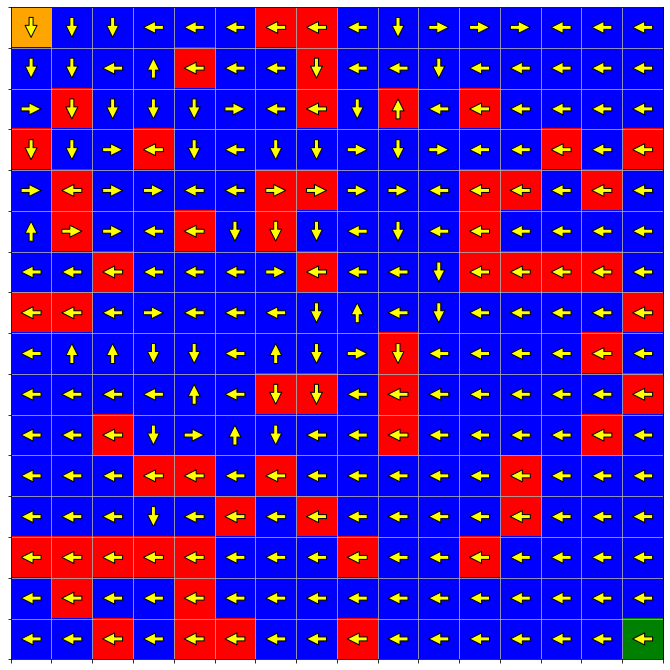

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(data, cmap=cmap)

# draw gridlines
ax.set_xticks(np.arange(-.5, 16.5, 1));
ax.set_yticks(np.arange(-.5, 16.5, 1));
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

for iy in range(16):
    for ix in range(16):
    #print(x)
        #if iy==1 and ix==1:
        #    continue
        #if iy==1 and ix==3:
        #    continue
        #if iy==3 and ix==0:
        #    continue
        #if iy==3 and ix==3:
        #    continue
        if act[iy,ix]=='down':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blue')
            ax.annotate('', xy=(ix, iy+0.25), xytext=(ix, iy-0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        elif act[iy,ix]=='left':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='green')
            ax.annotate('', xy=(ix-0.25, iy), xytext=(ix+0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        elif act[iy,ix]=='up':  
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blueviolet')
            ax.annotate('', xy=(ix, iy-0.25), xytext=(ix, iy+0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        else:
            ax.annotate('', xy=(ix+0.25, iy), xytext=(ix-0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.01))

In [18]:
print("Mean reward per thousand episodes")
mean_episode_rewards=[]
mean_episode_times=[]
episodes=np.arange(100,10000+100,100).astype('int')
for i in range(100):
    mean_reward=np.mean(rewards_per_episode[100*i:100*(i+1)])
    print((i+1)*100,": mean espiode reward: ",mean_reward)
    mean_episode_rewards.append(mean_reward)
    mean_time=np.mean(times_per_episode[100*i:100*(i+1)])
    mean_episode_times.append(mean_time)
print("\n\n")

Mean reward per thousand episodes
100 : mean espiode reward:  -3.3640000000000008
200 : mean espiode reward:  -3.2120000000000006
300 : mean espiode reward:  -3.0240000000000005
400 : mean espiode reward:  -3.508
500 : mean espiode reward:  -3.4120000000000004
600 : mean espiode reward:  -3.2280000000000006
700 : mean espiode reward:  -3.0060000000000007
800 : mean espiode reward:  -2.028
900 : mean espiode reward:  -1.9100000000000004
1000 : mean espiode reward:  -1.7600000000000002
1100 : mean espiode reward:  -1.6540000000000001
1200 : mean espiode reward:  -1.714
1300 : mean espiode reward:  -1.7240000000000004
1400 : mean espiode reward:  -1.7100000000000002
1500 : mean espiode reward:  -1.6660000000000001
1600 : mean espiode reward:  -1.6880000000000002
1700 : mean espiode reward:  -1.6440000000000001
1800 : mean espiode reward:  -1.572
1900 : mean espiode reward:  -1.51
2000 : mean espiode reward:  -1.4440000000000004
2100 : mean espiode reward:  -1.4680000000000002
2200 : mean 

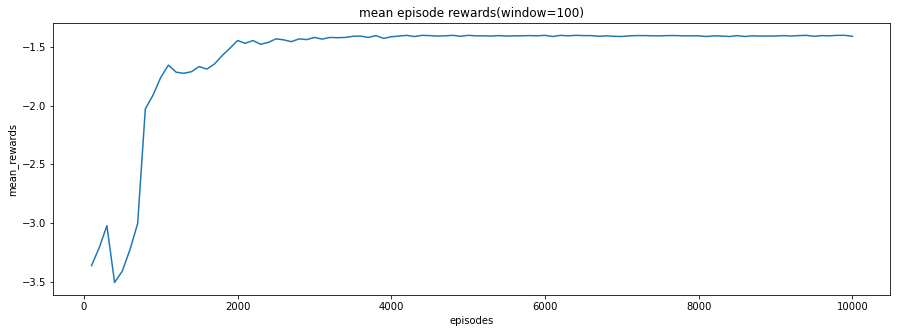

In [19]:
fig=plt.figure(figsize=[15,5])
plt.plot(episodes,mean_episode_rewards)
plt.title('mean episode rewards(window=100)')
plt.xlabel('episodes')
plt.ylabel('mean_rewards')
plt.show()

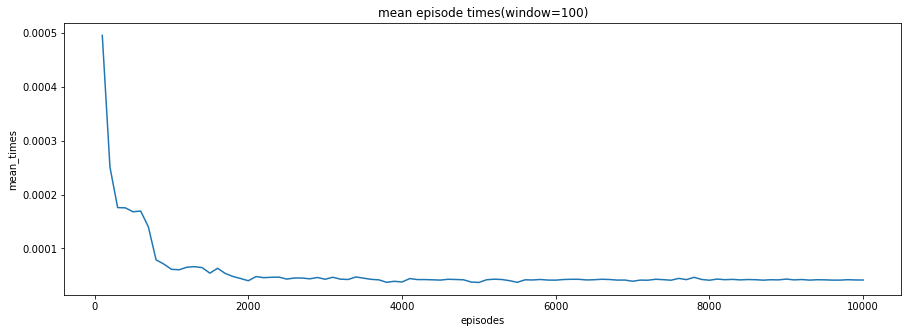

In [20]:
fig=plt.figure(figsize=[15,5])
plt.plot(episodes,mean_episode_times)
plt.title('mean episode times(window=100)')
plt.xlabel('episodes')
plt.ylabel('mean_times')
plt.show()

In [21]:
print('mean reward is ', np.mean(mean_episode_rewards))

mean reward is  -1.5764000000000002


In [22]:
print('mean time is ', np.mean(mean_episode_times))

mean time is  5.725789070129395e-05
